# Direct regression approach

In this case I want to get the number of corn kernels directly from the images via a regression. My plan is to use sophisticated model like VGG16 trained on a huge dataset like ImageNet as a feature extractor and then stack some linear layer to perform the regression. 


In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Data adquisition 

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"
train_csv_path = path+ "narrow_coco/narrow_kernel_test_labels.csv" 
train_data_path = path+ "narrow_coco/train_set" 


In [6]:
train_dataset = CustomImageDataset(train_csv_path, train_data_path)

In [7]:
train_dataset

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

In [9]:
train_dataloader

Feature batch shape: torch.Size([11, 3, 2309, 1732])
Labels batch shape: torch.Size([11])


TypeError: Invalid shape (3, 2309, 1732) for image data

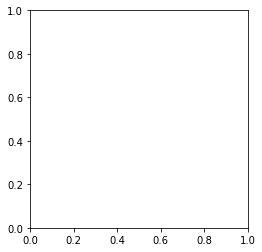

In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")